Europe tickers: ['CLNX.MC', 'ENEL.MI', 'ENGI.PA', 'FER.MC', 'IBDRY', 'NGG', 'RWE.DE', 'VGK']
Price columns: ['CLNX.MC', 'ENEL.MI', 'ENGI.PA', 'FER.MC', 'IBDRY', 'NGG', 'RWE.DE', 'VGK']


C:\Users\HP\AppData\Local\Temp\ipykernel_34844\3564775730.py:179: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  tr_returns_raw = tr_prices.pct_change()


Europe returns window: 2015-05-08 00:00:00 → 2024-12-31 00:00:00
Market proxy (Europe): VGK
Saved: summary_europe.csv, capm_europe.csv
Saved: risk_europe.csv


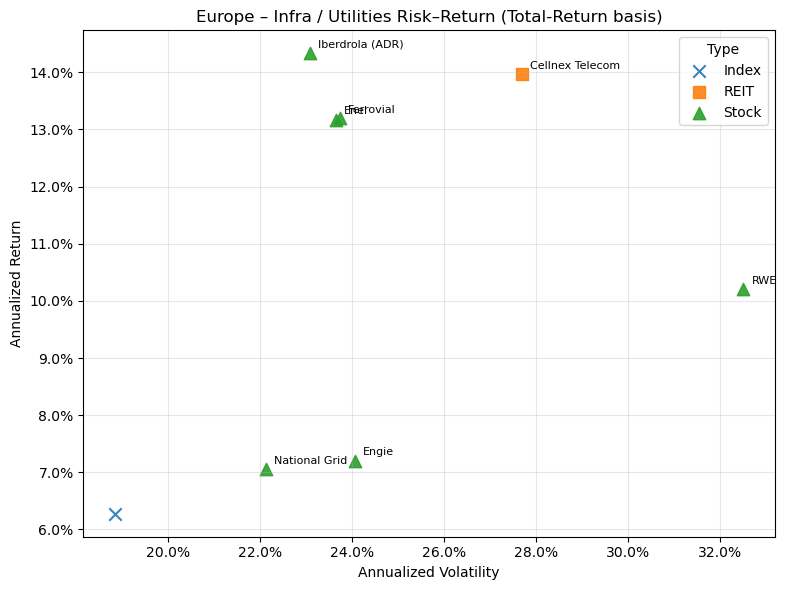

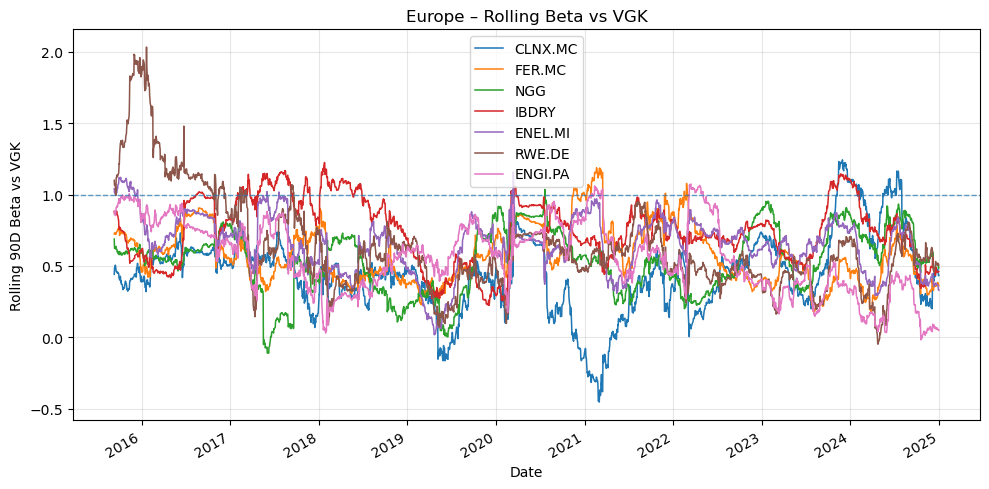

Europe – Type-wise averages:
Europe – Type Averages (Total-Return basis):


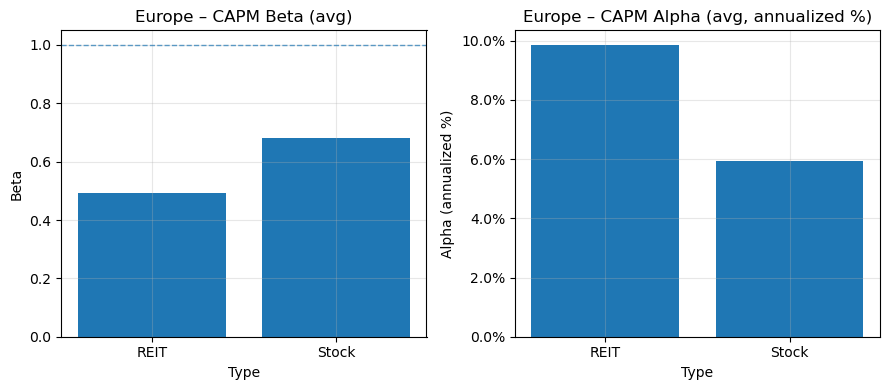

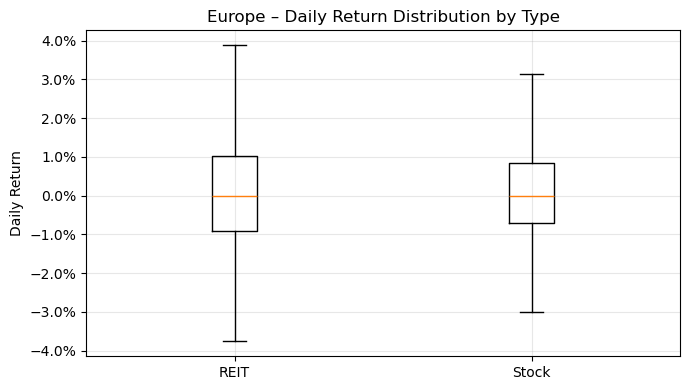

In [5]:
# ============================
# Europe Infrastructure / Utilities Analysis
# ============================

# Cell 1: Install & imports
!pip -q install yfinance statsmodels

import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

# ----------------------------
# Cell 2: Config & tickers
# ----------------------------
START = "2013-01-01"
END   = "2025-01-01"

RF_ANNUAL = 0.02      # simple constant RF for Europe (can refine later)
RF_DAILY  = RF_ANNUAL / 252
USE_COMMON_SAMPLE = True   # same window for all European assets

# Tower-like / infra REIT-style
reits_eu = [
    "CLNX.MC",  # Cellnex Telecom
]

# Infra / utilities / operators (expanded)
stocks_eu = [
    "FER.MC",   # Ferrovial
    "NGG",      # National Grid
    "IBDRY",    # Iberdrola (ADR)
    "ENEL.MI",  # Enel
    "RWE.DE",   # RWE
    "ENGI.PA",  # Engie
]

# Benchmark
indices_eu = [
    "VGK",      # Vanguard FTSE Europe ETF
]

MARKET_EU = "VGK"

tickers = sorted(set(reits_eu + stocks_eu + indices_eu))
print("Europe tickers:", tickers)

instrument_type = {}
for t in reits_eu:
    instrument_type[t] = "REIT"
for t in stocks_eu:
    instrument_type[t] = "Stock"
for t in indices_eu:
    instrument_type[t] = "Index"

instrument_meta = {
    "CLNX.MC": {"Name": "Cellnex Telecom", "Sector": "Tower / Telecom Infra"},
    "FER.MC":  {"Name": "Ferrovial", "Sector": "Transport Concessions"},
    "NGG":     {"Name": "National Grid", "Sector": "Electric & Gas Transmission"},
    "IBDRY":   {"Name": "Iberdrola (ADR)", "Sector": "Renewables & Power Networks"},
    "ENEL.MI": {"Name": "Enel", "Sector": "Electric Utility"},
    "RWE.DE":  {"Name": "RWE", "Sector": "Utility / Renewables"},
    "ENGI.PA": {"Name": "Engie", "Sector": "Energy / Utility"},
    "VGK":     {"Name": "Vanguard FTSE Europe ETF", "Sector": "Broad Europe Equity"},
}

# ============================
# Helpers & Core Calculations
# ============================

# Cell 3: Helper functions
def download_prices(tickers, start, end):
    df = yf.download(
        tickers, start=start, end=end,
        group_by="column", auto_adjust=False, progress=False
    )
    if isinstance(df.columns, pd.MultiIndex):
        top = df.columns.get_level_values(0).unique().tolist()
        field = "Adj Close" if "Adj Close" in top else "Close"
        prices_ = df[field].copy()
    else:
        prices_ = df.copy()

    if isinstance(prices_, pd.Series):
        prices_ = prices_.to_frame()

    drop_all_nan = [c for c in prices_.columns if prices_[c].dropna().empty]
    if drop_all_nan:
        print("Dropping tickers with no data:", drop_all_nan)
        prices_ = prices_.drop(columns=drop_all_nan)

    return prices_

def _normalize_dt_index(idx):
    idx = pd.to_datetime(idx, utc=True, errors="coerce")
    idx = idx.tz_convert(None).normalize()
    return idx

def total_return_series_from_price_and_dividends(px, div):
    px = px.dropna().copy()
    px.index = _normalize_dt_index(px.index)
    r_price = px.pct_change().fillna(0.0)

    r_div = pd.Series(0.0, index=px.index)
    if div is not None and not div.empty:
        div = div.copy()
        div.index = _normalize_dt_index(div.index)
        div = div.groupby(div.index).sum()
        aligned_cash = div.reindex(px.index).fillna(0.0)
        r_div = (aligned_cash / px.shift(1)).fillna(0.0)

    tr = (1.0 + r_price + r_div).cumprod()
    return tr

def capm_hac(excess_asset, excess_mkt, hac_lags=5):
    X = sm.add_constant(excess_mkt.values)
    y = excess_asset.values
    model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})
    alpha_d, beta = model.params
    return {
        "Alpha_annual": alpha_d * 252.0,
        "Beta": beta,
        "t_alpha": model.tvalues[0],
        "t_beta":  model.tvalues[1],
        "R2": float(model.rsquared),
        "N_obs": int(model.nobs),
    }

def max_drawdown(ret):
    cum = (1 + ret).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1.0
    return float(dd.min())

def sortino(ret, rf_daily):
    if isinstance(rf_daily, (int, float, np.floating)):
        ex = ret - rf_daily
    else:
        ex = ret - rf_daily.reindex(ret.index)
    downside = np.sqrt((ex[ex < 0] ** 2).mean() * 252)
    ann_ex_ret = ex.mean() * 252
    return float(ann_ex_ret / downside) if downside not in (0, np.nan) else np.nan

def var_cvar(ret, q=0.95):
    r = ret.dropna()
    if r.empty:
        return np.nan, np.nan
    cutoff = np.percentile(r, (1 - q) * 100)
    var  = -cutoff
    cvar = -r[r <= cutoff].mean()
    return float(var), float(cvar)

def rolling_beta(ret_df, market_col, window=90):
    var_m = ret_df[market_col].rolling(window).var()
    betas = {}
    for t in ret_df.columns:
        if t == market_col:
            continue
        cov_im = ret_df[t].rolling(window).cov(ret_df[market_col])
        betas[t] = cov_im / var_m
    return pd.DataFrame(betas)

# Cell 4: Download prices & build total-return panel
prices = download_prices(tickers, START, END)
print("Price columns:", prices.columns.tolist())

tr_prices = prices.copy()
tickers_tr = [t for t in reits_eu if t in prices.columns]  # total-return for REITs

for t in tickers_tr:
    div = yf.Ticker(t).dividends
    tr_prices[t] = total_return_series_from_price_and_dividends(prices[t], div)

tr_returns_raw = tr_prices.pct_change()

if USE_COMMON_SAMPLE:
    cols = [c for c in tr_returns_raw.columns if c in tickers]
    tr_returns = tr_returns_raw[cols].dropna(how="any")
else:
    tr_returns = tr_returns_raw.copy()

print("Europe returns window:", tr_returns.index.min(), "→", tr_returns.index.max())

# ============================
# Summary, CAPM, Risk & Plots
# ============================

# Cell 5: Summary metrics (Annual return, vol, Sharpe)
daily_mean = tr_returns.mean()
daily_vol  = tr_returns.std()

annual_ret = daily_mean * 252
annual_vol = daily_vol  * np.sqrt(252)
sharpe     = (annual_ret - RF_ANNUAL) / annual_vol

summary = pd.DataFrame({
    "Annual_Return": annual_ret,
    "Annual_Volatility": annual_vol,
    "Sharpe_Ratio": sharpe
})

summary["Type"]   = summary.index.map(instrument_type.get)
summary["Name"]   = summary.index.map(lambda x: instrument_meta.get(x, {}).get("Name", x))
summary["Sector"] = summary.index.map(lambda x: instrument_meta.get(x, {}).get("Sector", ""))

summary = summary[["Name","Type","Sector","Annual_Return","Annual_Volatility","Sharpe_Ratio"]]
summary

# Cell 6: CAPM vs VGK (Total-return basis)
if MARKET_EU not in tr_returns.columns:
    raise ValueError(f"{MARKET_EU} not in tr_returns columns: {tr_returns.columns.tolist()}")

rf_series = pd.Series(RF_DAILY, index=tr_returns.index)

capm_rows = []
for t in tr_returns.columns:
    if t == MARKET_EU:
        continue
    df = tr_returns[[t, MARKET_EU]].dropna()
    if df.empty:
        continue
    ex_i = df[t] - rf_series.reindex(df.index)
    ex_m = df[MARKET_EU] - rf_series.reindex(df.index)
    res = capm_hac(ex_i, ex_m, hac_lags=5)
    res["Ticker"] = t
    capm_rows.append(res)

capm_eu = pd.DataFrame(capm_rows).set_index("Ticker")
capm_eu = capm_eu.join(summary[["Name","Type","Sector"]], how="left")

capm_disp = capm_eu.copy()
capm_disp["Alpha_annual"] = (capm_disp["Alpha_annual"]*100).round(2)
capm_disp["Beta"]         = capm_disp["Beta"].round(2)
capm_disp["t_alpha"]      = capm_disp["t_alpha"].round(2)
capm_disp["t_beta"]       = capm_disp["t_beta"].round(2)
capm_disp["R2"]           = capm_disp["R2"].round(2)

capm_disp = capm_disp[["Name","Type","Sector","Alpha_annual","Beta","t_alpha","t_beta","R2","N_obs"]]
print("Market proxy (Europe):", MARKET_EU)
capm_disp

# Cell 7: Save core outputs (for comparison notebook)
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

summary_out = summary.copy()
summary_out["Region"] = "Europe"
summary_out.to_csv("summary_europe.csv", index_label="Ticker")

capm_out = capm_eu.copy()
capm_out["Region"] = "Europe"
capm_out.to_csv("capm_europe.csv", index_label="Ticker")

print("Saved: summary_europe.csv, capm_europe.csv")

# Cell 8: Downside risk metrics (Max Drawdown, Sortino, VaR/CVaR)
rf_series_const = pd.Series(RF_DAILY, index=tr_returns.index)

risk_rows = []
for t in tr_returns.columns:
    r = tr_returns[t].dropna()
    if r.empty:
        continue
    VaR95, CVaR95 = var_cvar(r, 0.95)
    risk_rows.append({
        "Ticker": t,
        "Max_Drawdown": max_drawdown(r),
        "Sortino": sortino(r, rf_series_const),
        "VaR_95": VaR95,
        "CVaR_95": CVaR95
    })

risk_eu = (
    pd.DataFrame(risk_rows)
      .set_index("Ticker")
      .join(summary[["Name","Type","Sector"]], how="left")
      [["Name","Type","Sector","Max_Drawdown","Sortino","VaR_95","CVaR_95"]]
)

risk_eu

risk_eu_out = risk_eu.copy()
risk_eu_out["Region"] = "Europe"
risk_eu_out.to_csv("risk_europe.csv")
print("Saved: risk_europe.csv")

# Cell 9: Correlation matrix (Europe)
corr_eu = tr_returns.corr()
corr_eu

# Cell 10: Risk–Return scatter (Europe)
BASE_RETURNS = tr_returns

ann_ret_eu = BASE_RETURNS.mean() * 252
ann_vol_eu = BASE_RETURNS.std()  * np.sqrt(252)

scatter_eu = pd.DataFrame({
    "Annual_Return": ann_ret_eu,
    "Annual_Volatility": ann_vol_eu,
    "Type": [instrument_type.get(t, "Other") for t in ann_ret_eu.index],
    "Name": [instrument_meta.get(t, {}).get("Name", t) for t in ann_ret_eu.index]
})

marker_map = {"REIT":"s", "Stock":"^", "Index":"x", "Other":"o"}

plt.figure(figsize=(8,6))
for tp, grp in scatter_eu.groupby("Type"):
    plt.scatter(grp["Annual_Volatility"], grp["Annual_Return"],
                marker=marker_map.get(tp, "o"), label=tp, s=80, alpha=0.9)

for idx, row in scatter_eu[scatter_eu["Type"] != "Index"].iterrows():
    label = row["Name"] if len(str(row["Name"])) <= 18 else idx
    plt.annotate(label,
                 (row["Annual_Volatility"], row["Annual_Return"]),
                 textcoords="offset points", xytext=(6,4), fontsize=8)

plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Europe – Infra / Utilities Risk–Return (Total-Return basis)")
plt.grid(True, alpha=0.3)
plt.legend(title="Type")
plt.tight_layout()
plt.show()

# Cell 11: Rolling 90-day beta vs VGK
rb_eu = rolling_beta(tr_returns, MARKET_EU, window=90)

TICKERS_TO_PLOT = [t for t in ["CLNX.MC","FER.MC","NGG","IBDRY","ENEL.MI","RWE.DE","ENGI.PA"] if t in rb_eu.columns]

plt.figure(figsize=(10,5))
rb_eu[TICKERS_TO_PLOT].dropna().plot(ax=plt.gca(), linewidth=1.1)
plt.axhline(1.0, linestyle="--", linewidth=1, alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Rolling 90D Beta vs " + MARKET_EU)
plt.title("Europe – Rolling Beta vs VGK")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Cell 12: Type-wise summary inside Europe
summary_eu_type = (
    summary
      .groupby("Type")
      .agg(
          Count=("Annual_Return","count"),
          Ann_Return_mean=("Annual_Return","mean"),
          Ann_Vol_mean=("Annual_Volatility","mean"),
          Sharpe_mean=("Sharpe_Ratio","mean")
      )
)

sum_eu_disp = summary_eu_type.copy()
sum_eu_disp["Ann_Return_mean"] = (sum_eu_disp["Ann_Return_mean"]*100).round(2)
sum_eu_disp["Ann_Vol_mean"]    = (sum_eu_disp["Ann_Vol_mean"]*100).round(2)
sum_eu_disp["Sharpe_mean"]     = sum_eu_disp["Sharpe_mean"].round(2)
sum_eu_disp.rename(columns={
    "Ann_Return_mean":"Ann. Return (avg) %",
    "Ann_Vol_mean":"Ann. Vol (avg) %",
    "Sharpe_mean":"Sharpe (avg)"
}, inplace=True)

print("Europe – Type-wise averages:")
sum_eu_disp

# Cell 13: Type Averages (Total-Return basis) – incl. CAPM
types_of_interest = ["InvIT", "MLP", "REIT", "Stock"]

type_metrics_eu = (
    summary
      .query("Type in @types_of_interest")
      .groupby("Type")
      .agg(
          Count=("Annual_Return", "count"),
          Ann_Return_mean=("Annual_Return", "mean"),
          Ann_Return_median=("Annual_Return", "median"),
          Ann_Vol_mean=("Annual_Volatility", "mean"),
          Sharpe_mean=("Sharpe_Ratio", "mean")
      )
)

type_capm_eu = (
    capm_eu
      .query("Type in @types_of_interest")
      .groupby("Type")
      .agg(
          Alpha_mean=("Alpha_annual", "mean"),
          Beta_mean=("Beta", "mean"),
          R2_mean=("R2", "mean")
      )
)

type_summary_eu = type_metrics_eu.join(type_capm_eu, how="left")

ts_eu = type_summary_eu.copy()
for c in ["Ann_Return_mean", "Ann_Return_median", "Ann_Vol_mean", "Alpha_mean"]:
    ts_eu[c] = (ts_eu[c] * 100).round(2)

ts_eu["Sharpe_mean"] = ts_eu["Sharpe_mean"].round(2)
ts_eu["Beta_mean"]   = ts_eu["Beta_mean"].round(2)
ts_eu["R2_mean"]     = ts_eu["R2_mean"].round(2)

ts_eu.rename(columns={
    "Ann_Return_mean":   "Ann. Return (avg) %",
    "Ann_Return_median": "Ann. Return (median) %",
    "Ann_Vol_mean":      "Ann. Vol (avg) %",
    "Sharpe_mean":       "Sharpe (avg)",
    "Alpha_mean":        "Alpha (avg) %",
    "Beta_mean":         "Beta (avg)",
    "R2_mean":           "R² (avg)"
}, inplace=True)

print("Europe – Type Averages (Total-Return basis):")
ts_eu

# Cell 14: CAPM Beta (avg) and Alpha (avg, annualized %) – Europe
ts_plot_eu = type_summary_eu.copy()

fig, axes = plt.subplots(1, 2, figsize=(9,4))

axes[0].bar(ts_plot_eu.index, ts_plot_eu["Beta_mean"])
axes[0].axhline(1.0, linestyle="--", linewidth=1, alpha=0.7)
axes[0].set_title("Europe – CAPM Beta (avg)")
axes[0].set_xlabel("Type")
axes[0].set_ylabel("Beta")
axes[0].grid(True, alpha=0.3)

alpha_pct_eu = ts_plot_eu["Alpha_mean"] * 100
axes[1].bar(ts_plot_eu.index, alpha_pct_eu)
axes[1].yaxis.set_major_formatter(PercentFormatter(100))
axes[1].set_title("Europe – CAPM Alpha (avg, annualized %)")
axes[1].set_xlabel("Type")
axes[1].set_ylabel("Alpha (annualized %)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 15: Daily Return Distribution by Type – Europe
stack_rows = []
for c in tr_returns.columns:
    t_type = instrument_type.get(c, "Other")
    if t_type in ["InvIT", "MLP", "REIT", "Stock"]:
        df_tmp = pd.DataFrame({
            "Ticker": c,
            "Type": t_type,
            "Ret": tr_returns[c].dropna()
        })
        stack_rows.append(df_tmp)

if stack_rows:
    stack_eu = pd.concat(stack_rows, axis=0)

    ordered_types = ["InvIT", "MLP", "REIT", "Stock"]
    data = [stack_eu.loc[stack_eu["Type"] == t, "Ret"]
            for t in ordered_types if t in stack_eu["Type"].unique()]
    labels = [t for t in ordered_types if t in stack_eu["Type"].unique()]

    fig, ax = plt.subplots(figsize=(7,4))
    ax.boxplot(data, labels=labels, showfliers=False)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.set_title("Europe – Daily Return Distribution by Type")
    ax.set_ylabel("Daily Return")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No returns available for InvIT/MLP/REIT/Stock in Europe sample.")


In [6]:
# Cell 12: Type-wise summary inside US (extended with median and CAPM averages)

summary_us_type = (
    summary
      .groupby("Type")
      .agg(
          Count=("Annual_Return","count"),
          Ann_Return_mean=("Annual_Return","mean"),
          Ann_Return_median=("Annual_Return","median"),
          Ann_Vol_mean=("Annual_Volatility","mean"),
          Sharpe_mean=("Sharpe_Ratio","mean")
      )
)

# CAPM averages by Type (capm_us includes Alpha_annual, Beta, R2 and was already joined with Type)
capm_by_type = (
    capm_eu[["Alpha_annual","Beta","R2","Type"]]
      .groupby("Type")
      .mean()
      .rename(columns={
          "Alpha_annual": "Alpha_avg",
          "Beta": "Beta_avg",
          "R2": "R2_avg"
      })
)

# Join and format for display
summary_us_type = summary_us_type.join(capm_by_type, how="left")

sum_disp = summary_us_type.copy()
sum_disp["Ann. Return (avg) %"]   = (sum_disp["Ann_Return_mean"] * 100).round(2)
sum_disp["Ann. Return (median) %"] = (sum_disp["Ann_Return_median"] * 100).round(2)
sum_disp["Ann. Vol (avg) %"]      = (sum_disp["Ann_Vol_mean"] * 100).round(2)
sum_disp["Sharpe (avg)"]          = sum_disp["Sharpe_mean"].round(2)
sum_disp["Alpha (avg) %"]         = (sum_disp["Alpha_avg"] * 100).round(2)
sum_disp["Beta (avg)"]            = sum_disp["Beta_avg"].round(2)
sum_disp["R² (avg)"]              = sum_disp["R2_avg"].round(2)

# final column order
sum_disp = sum_disp[
    ["Count",
     "Ann. Return (avg) %",
     "Ann. Return (median) %",
     "Ann. Vol (avg) %",
     "Sharpe (avg)",
     "Alpha (avg) %",
     "Beta (avg)",
     "R² (avg)"]
]

sum_disp


,Count,Ann. Return (avg) %,Ann. Return (median) %,Ann. Vol (avg) %,Sharpe (avg),Alpha (avg) %,Beta (avg),R² (avg)
Type,,,,,,,,
Index,1,6.2800,6.2800,18.8500,0.2300,NaN,NaN,NaN
REIT,1,13.9700,13.9700,27.7100,0.4300,9.8600,0.4900,0.1100
Stock,6,10.8600,11.6800,24.8700,0.3600,5.9500,0.6800,0.2800


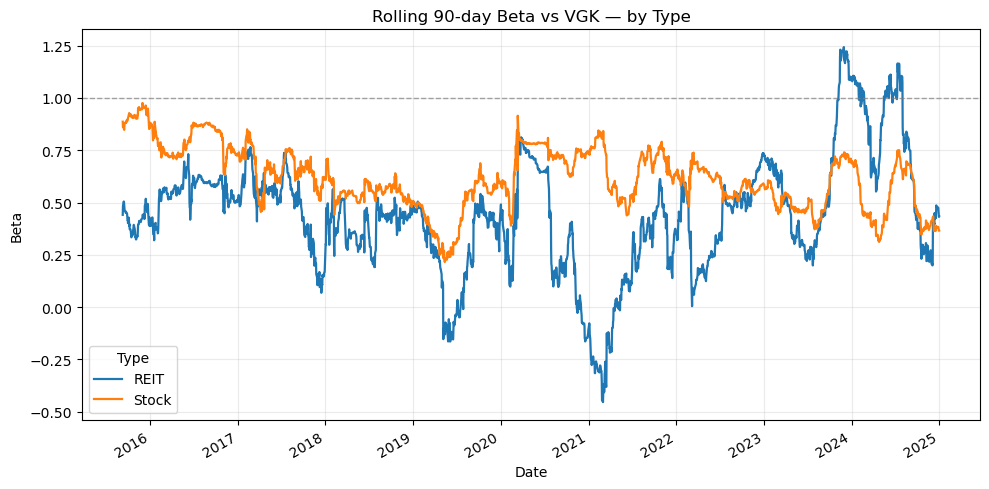

In [8]:
# ...existing code...
# 90-day rolling beta by Type (Index, REIT, Stock) — Python version
window = 90
types_to_plot = ["Index", "REIT", "Stock"]

# map tickers by type, keeping only those present in rb_eu
type_tickers = {
    tp: [t for t, tt in instrument_type.items() if tt == tp and t in rb_eu.columns]
    for tp in types_to_plot
}

# build DataFrame with mean rolling beta per type
type_rb = pd.DataFrame(index=rb_eu.index)
for tp, cols in type_tickers.items():
    if cols:
        type_rb[tp] = rb_eu[cols].mean(axis=1)

# Plot
plt.figure(figsize=(10,5))
ax = plt.gca()
type_rb.dropna(how="all").plot(ax=ax, linewidth=1.6)
ax.axhline(1.0, linestyle="--", color="gray", linewidth=1, alpha=0.7)
ax.set_title(f"Rolling {window}-day Beta vs {MARKET_EU} — by Type")
ax.set_xlabel("Date")
ax.set_ylabel("Beta")
ax.grid(True, alpha=0.25)
plt.legend(title="Type")
plt.tight_layout()
plt.show()
# ...existing code...